## Цели и задачи проекта 

**Цель** - анализ данных и выборка признаков модели

**Задачи** 
    - проверить качество данных
    - провести корреляционный анализ количественных признаков
    - выбор признаков влияющих на баллы по математике

## Информация о данных  
Закономерености данных:

- нет в данных строковых данных, чтобы они отображадлись "криво" (неполно), поэтому не стал внедрнять функцию обработки стокровых столбцов (как функция fix_countries в примере )

- почти все числовые характириски являются по факту номинативными, но выраженными числами

- при обработке выбросов замечено, что у некоторых столбцов 25 процентиль равен 75 процентилю, в этом случае я не проводил фильтрацию данных по выбросам (данные надо удалять осторожно !!!!)

- логика обработки данных следующая

    - поиск пропусков и замена их на None
    - проверка того, что значение имеет валидное значение если невалидное значение замена его на None
    - заполнение пропусков в строках модами, самыми встречающими значениями
    - фильтрация выбросов
    
 Такой подход позволил сохранить большинство значений в выборке (300 значений)


## Этапы работа:
1. Первичная обработка данных, устранение выбросов, замена пропусков на моду и т.п.
2. Анализ распределения  числовых  признаков
3. Анализ распределения  номинативных   признаков
4. Корреляционный анализ  числовых  признаков
5. Анализ номинативных переменных и устранить те, которые не влияют на предсказываемую величину 
6. Выводы

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings("ignore")

### Функции бывают:
*простые* -  выполняющие только простые действия например: замена пропуска значения на None, фильтрация выбросов и
*составные* - состоят из простых функций

**простые**
 - determNoneValue - замена пропусков данных  модами
 - outliersData - функция фильтраци выбросов
 - replaceEmptySkipValue -  универсаклная функция замены пропуска  none
 
**составные**  
 - ordanaryValidValue - преобразование незвестного значения
 - permitValidValue -  фильтрация данных на валидных значениях + значение по умочанию
 - permitPositivValue - фильтрация положительных данных



In [94]:
#  универсаклная функция замены пропуска  none
def replaceEmptySkipValue(data, columns):
    for column in columns:
        data[column] = data[column].apply(
            lambda x: None if pd.isnull(x) else (None if (x == 'nan' or str(x).strip() == '') else x))
    return data


# преобразование незвестного значения
def ordanaryValidValue(data, column, needOutliersData=False):
    data = replaceEmptySkipValue(data, [column])

    data = determNoneValue(data, column)

    if needOutliersData:
        data = outliersData(data, column)

    return data


# фильтрация данных на валидных значениях + значение по умочанию
def permitValidValue(data, column, premit_value, defaulVaue=None, needOutliersData=False):
    data = replaceEmptySkipValue(data, [column])

    data[column] = data[column].apply(lambda x: x if x in premit_value else defaulVaue)

    data = determNoneValue(data, column)
    if needOutliersData:
        data = outliersData(data, column)
    return data


# фильтрация положительных данных
def permitPositivValue(data, column, defaulVaue=None, needOutliersData=False):
    data = replaceEmptySkipValue(data, [column])
    data[column] = data[column].apply(lambda x: int(x) if x >= 0 else defaulVaue)

    data = determNoneValue(data, column)
    if needOutliersData:
        data = outliersData(data, column)

    return data


# замена пропусков данных модами
def determNoneValue(data, column):
    value_ = data[column].mode()[0]
    data.loc[:, column].fillna(value_, inplace=True)
    return data


#  функция фильтраци выбросов - если квинтили равны  -  не делаем выросы - распределени примено одинаково
def outliersData(data, column):
    quantile_3 = data[column].quantile(0.75)
    quantile_1 = data[column].quantile(0.25)
    if quantile_3 == quantile_1:
        return data

    IQR = quantile_3 - quantile_1
    column_min = quantile_1 - 1.5 * IQR
    column_max = quantile_3 + 1.5 * IQR

    data = data[data[column].between(column_min, column_max)]
    return data


## 1. Первичная обработка данных, устранение выбросов, замена пропусков на моду и т.п.
### Загрузка данных:

In [96]:
student = pd.read_csv("stud_math.xls")
#  неизвестный столбец - лишнеи данные не помешают 
student.rename(columns={'studytime, granular': 'granular'}, inplace=True)

##  2. Анализ распределения  числовых  признаков

**Age** - выбросов нет, значение лежит в интервале от 15 до 22

<AxesSubplot:>

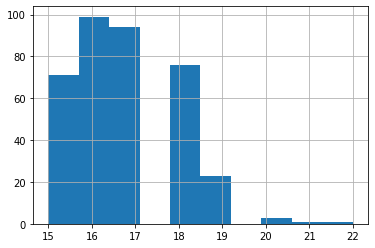

In [100]:
student = permitPositivValue(student, 'age')
student['age'].hist()

**granular** - неизвестный параметр

<AxesSubplot:>

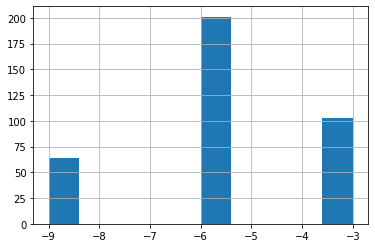

In [101]:
student = ordanaryValidValue(student, 'granular', needOutliersData=True)
student['granular'].hist()

**Medu** - образование матери , доступыне значения (0,1,2,3,4)

<AxesSubplot:>

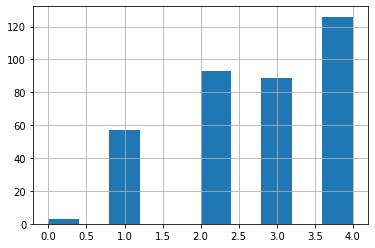

In [102]:
student = permitValidValue(student, 'Medu', [0, 1, 2, 3, 4], needOutliersData=True)
student['Medu'].hist()

**Fedu** - образование отца , доступыне значения (0,1,2,3,4)

<AxesSubplot:>

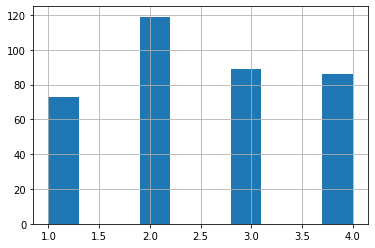

In [103]:
student = permitValidValue(student, 'Fedu', [0, 1, 2, 3, 4], needOutliersData=True)
student['Fedu'].hist()

**traveltime** - время в пути до школы (1,2,3,4)

<AxesSubplot:>

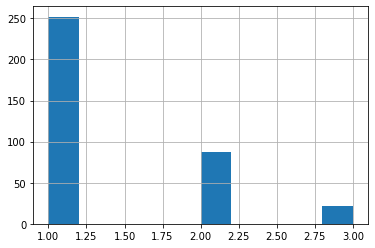

In [107]:
student = permitValidValue(student, 'traveltime', [1, 2, 3, 4], needOutliersData=True)
student['traveltime'].hist()

**studytime**  - время на учёбу помимо школы в неделю

<AxesSubplot:>

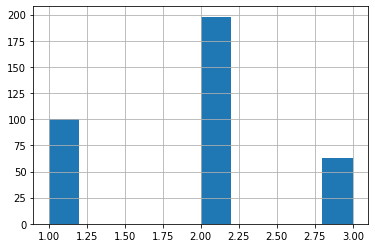

In [108]:
student = permitValidValue(student, 'studytime', [1, 2, 3, 4], needOutliersData=True)
student['studytime'].hist()

**failures**- количество внеучебных неудач

<AxesSubplot:>

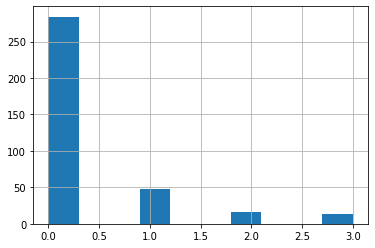

In [109]:
student = permitValidValue(student, 'failures', [1, 2, 3], defaulVaue=0, needOutliersData=True)
student['failures'].hist()

**famrel** - семейные отношения

<AxesSubplot:>

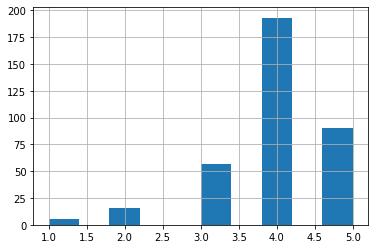

In [110]:
student = permitValidValue(student, 'famrel', [1, 2, 3, 4, 5], needOutliersData=True)
student['famrel'].hist()

**freetime** - свободное время после школы

<AxesSubplot:>

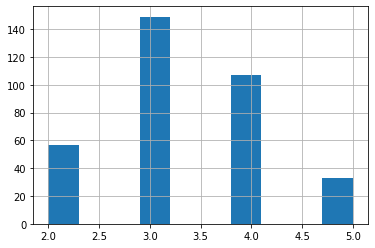

In [111]:
student = permitValidValue(student, 'freetime', [1, 2, 3, 4, 5], needOutliersData=True)
student['freetime'].hist()

**goout** - проведение времени с друзьями

<AxesSubplot:>

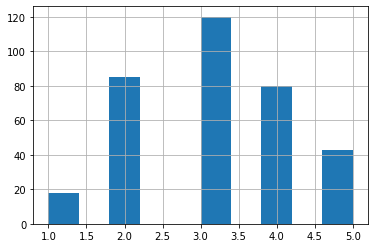

In [112]:
student = permitValidValue(student, 'goout', [1, 2, 3, 4, 5], needOutliersData=True)
student['goout'].hist()

**goout** - текущее состояние здоровья

<AxesSubplot:>

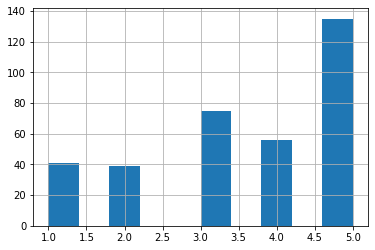

In [113]:
student = permitValidValue(student, 'health', [1, 2, 3, 4, 5], needOutliersData=True)
student['health'].hist()

**absences**  -  количество пропущенных занятий

<AxesSubplot:>

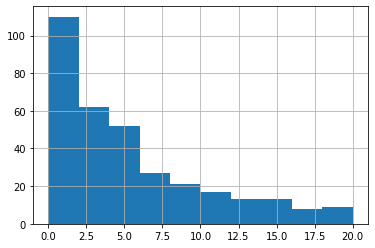

In [114]:
student = permitPositivValue(student, 'absences', needOutliersData=True)
student['absences'].hist()

**score** — баллы по госэкзамену по математике

<AxesSubplot:>

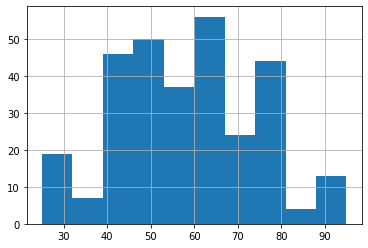

In [115]:
student = permitPositivValue(student, 'score', needOutliersData=True)
student['score'].hist()

## 3. Анализ распределения номинативных признаков

**sex** — пол ученика ('F' - женский, 'M' - мужской)

<AxesSubplot:>

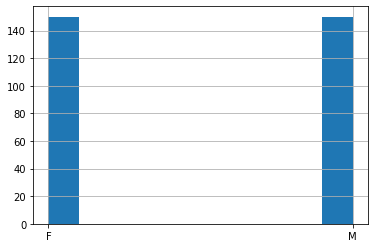

In [116]:
student = permitValidValue(student, 'sex', ['F', 'M'])
student['sex'].hist()

**address** — тип адреса ученика ('U' - городской, 'R' - за городом)

<AxesSubplot:>

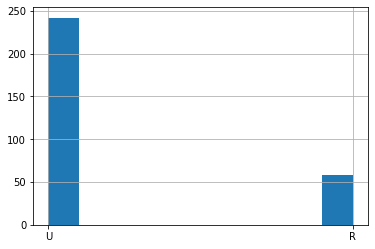

In [117]:
student = permitValidValue(student, 'address', ['U', 'R'])
student['address'].hist()

**famsize** — размер семьи('LE3' <= 3, 'GT3' >3)

<AxesSubplot:>

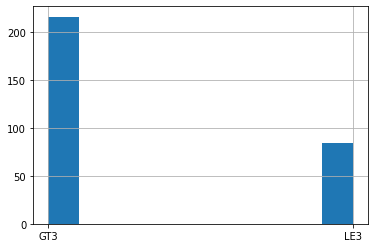

In [119]:
student = permitValidValue(student, 'famsize', ['LE3', 'GT3'])
student['famsize'].hist()

**Pstatus** - статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

<AxesSubplot:>

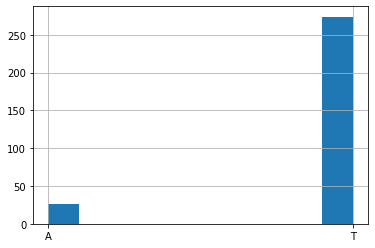

In [120]:
student = permitValidValue(student, 'Pstatus', ['T', 'A'])
student['Pstatus'].hist()

**Mjob** - работа матери

<AxesSubplot:>

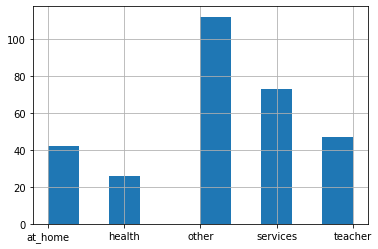

In [121]:
student = permitValidValue(student, 'Mjob', ['teacher', 'health', 'services', 'at_home', 'other'])
student['Mjob'].hist()

**Fjob**  - работа отца

<AxesSubplot:>

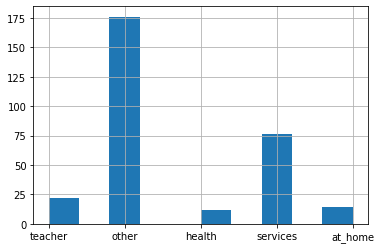

In [125]:
student = permitValidValue(student, 'Fjob', ['teacher', 'health', 'services', 'at_home', 'other'])
student['Fjob'].hist()

**reason**  — причина выбора школы

<AxesSubplot:>

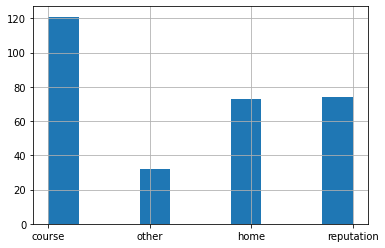

In [127]:
student = permitValidValue(student, 'reason', ['home', 'reputation', 'course', 'other'])
student['reason'].hist()

**guardian**  — опекун

<AxesSubplot:>

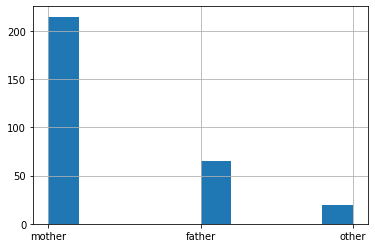

In [128]:
student = permitValidValue(student, 'guardian', ['mother', 'father', 'other'])
student['guardian'].hist()

**schoolsup** - дополнительная образовательная поддержка

<AxesSubplot:>

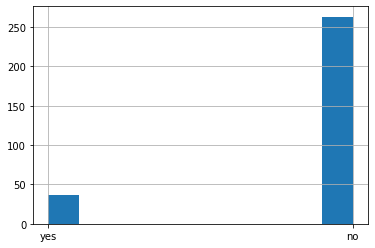

In [129]:
student = permitValidValue(student, 'schoolsup', ['yes', 'no'])
student['schoolsup'].hist()

**famsup** — семейная образовательная поддержка

<AxesSubplot:>

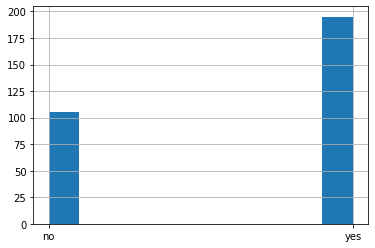

In [131]:
student = permitValidValue(student, 'famsup', ['yes', 'no'])
student['famsup'].hist()

**paid** — дополнительные платные занятия по математике

<AxesSubplot:>

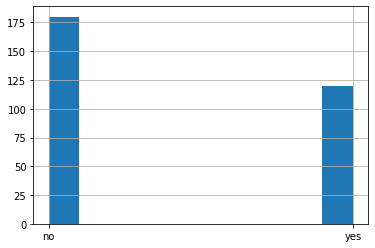

In [135]:
student = permitValidValue(student, 'paid', ['yes', 'no'])
student['paid'].hist()

**activities** — дополнительные внеучебные занятия

<AxesSubplot:>

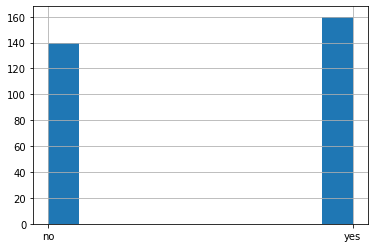

In [136]:
student = permitValidValue(student, 'activities', ['yes', 'no'])
student['activities'].hist()

**nursery** — посещал детский сад

<AxesSubplot:>

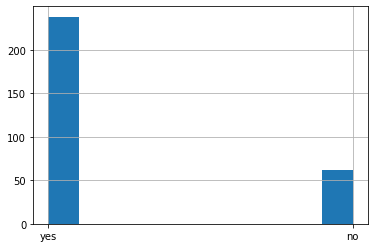

In [137]:
student = permitValidValue(student, 'nursery', ['yes', 'no'])
student['nursery'].hist()

**higher** — хочет получить высшее образование

<AxesSubplot:>

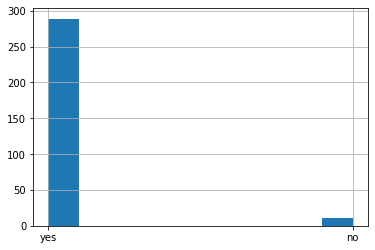

In [138]:
student = permitValidValue(student, 'higher', ['yes', 'no'])
student['higher'].hist()

**internet** — наличие интернета дома

<AxesSubplot:>

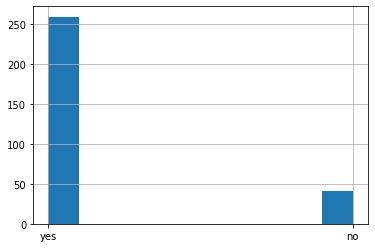

In [139]:
student = permitValidValue(student, 'internet', ['yes', 'no'])
student['internet'].hist()

**romantic** — в романтических отношениях

<AxesSubplot:>

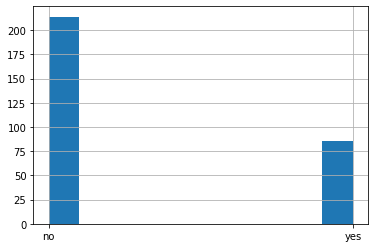

In [140]:
student = permitValidValue(student, 'romantic', ['yes', 'no'])
student['romantic'].hist()

## 4. Корреляционный анализ числовых признаков
Взаимосвязи между числовыми параметрам (плохо поддается анализу!)

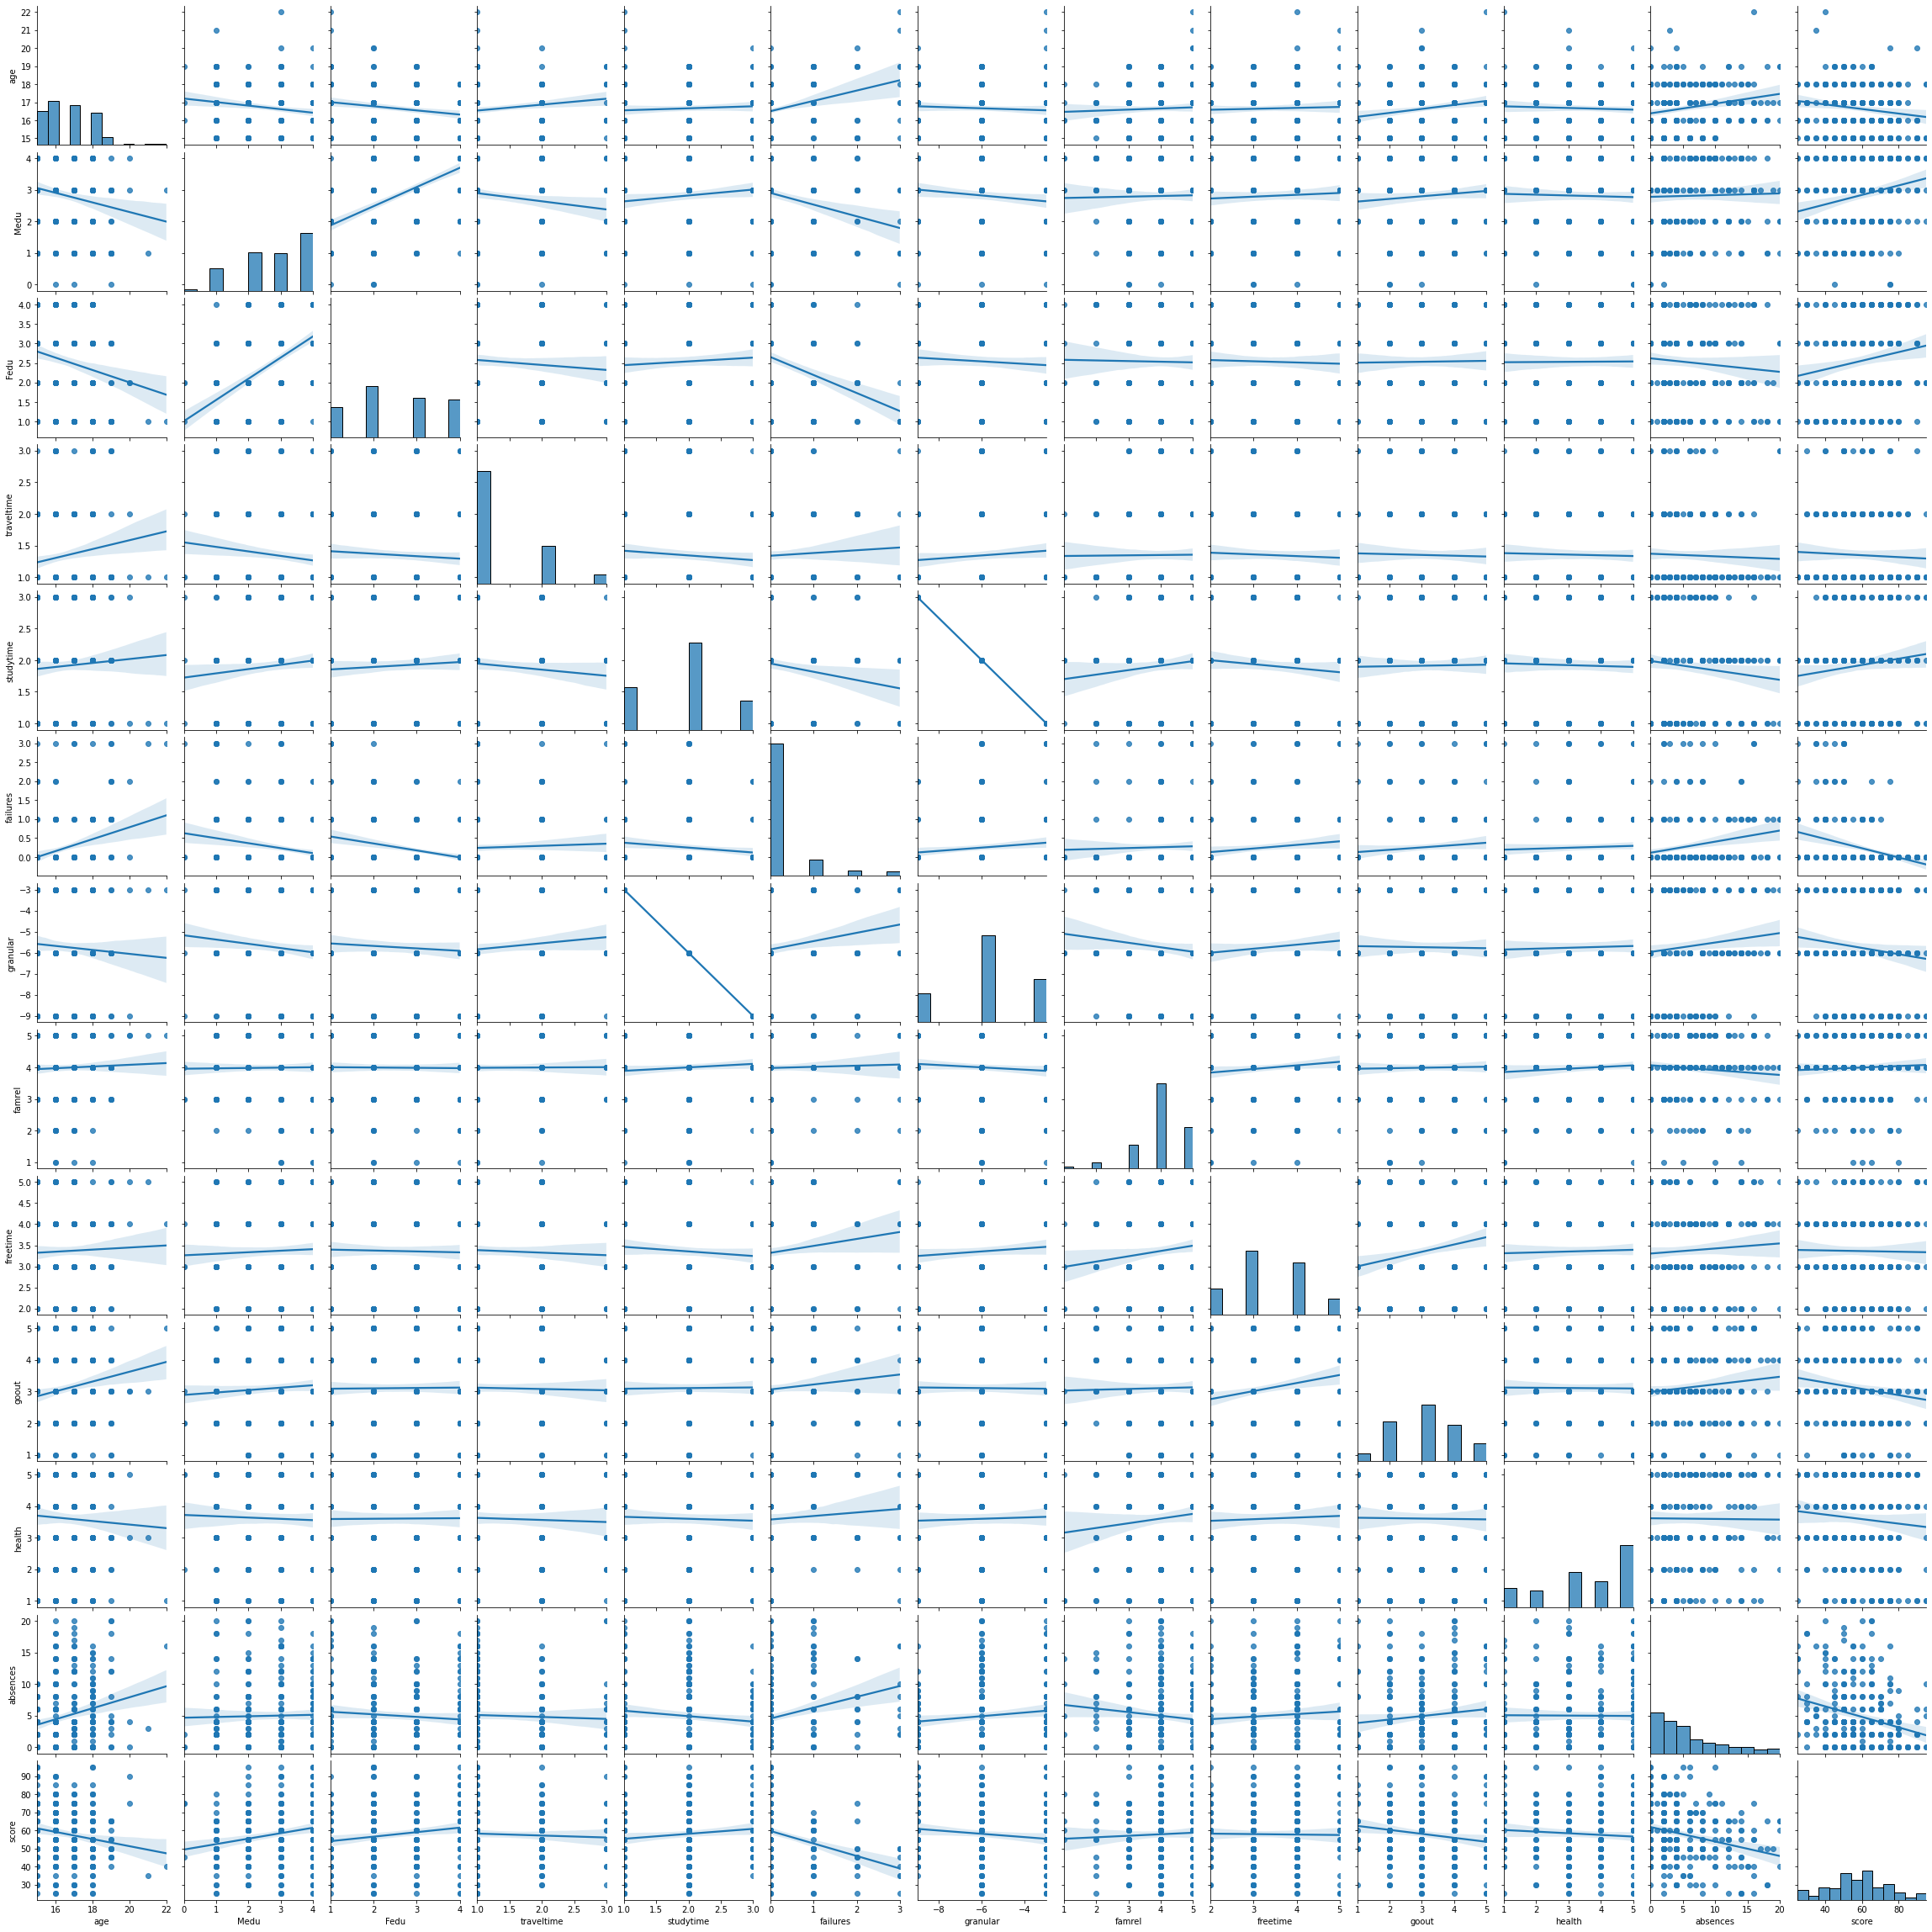

In [147]:
sns.pairplot(student, kind = 'reg')

### Вывод сильно скорелированных значений

In [148]:
correlation = student.corr()
print(correlation[(correlation >= 0.4) | (correlation <= -0.4)])

            age      Medu      Fedu  traveltime  studytime  failures  \
age         1.0       NaN       NaN         NaN        NaN       NaN   
Medu        NaN  1.000000  0.573589         NaN        NaN       NaN   
Fedu        NaN  0.573589  1.000000         NaN        NaN       NaN   
traveltime  NaN       NaN       NaN         1.0        NaN       NaN   
studytime   NaN       NaN       NaN         NaN        1.0       NaN   
failures    NaN       NaN       NaN         NaN        NaN       1.0   
granular    NaN       NaN       NaN         NaN       -1.0       NaN   
famrel      NaN       NaN       NaN         NaN        NaN       NaN   
freetime    NaN       NaN       NaN         NaN        NaN       NaN   
goout       NaN       NaN       NaN         NaN        NaN       NaN   
health      NaN       NaN       NaN         NaN        NaN       NaN   
absences    NaN       NaN       NaN         NaN        NaN       NaN   
score       NaN       NaN       NaN         NaN        NaN      

**Выводы** на основе корреляционного анализа количественных переменных:
- неизвестный параметр granular  полностью коррелируется с studytime (studytime - предварительно убираем с выборки)
- образование отца и матери коорелируется тоже, из этого можно сделать выход что семьи создаются в том числе и на основе 
уровня образованности родителей

## 5. Анализ номинативных переменных и устранить те, которые не влияют на предсказываемую величину 

Так как числовые показатели по факту являются и номитативными переменными, только выраженными цифрами, они тоже будут учавствовать в расчете

In [149]:
def get_boxplot(date, column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score',
                data=date.loc[:],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

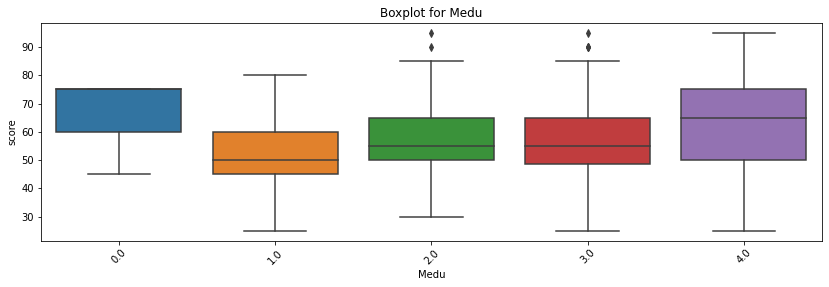

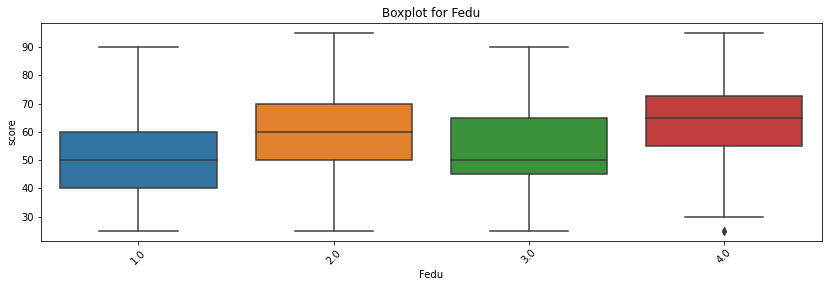

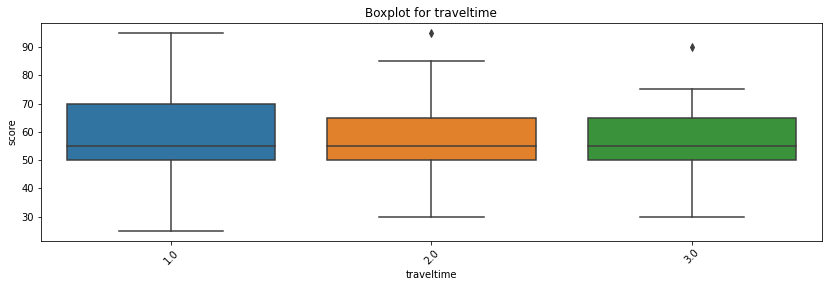

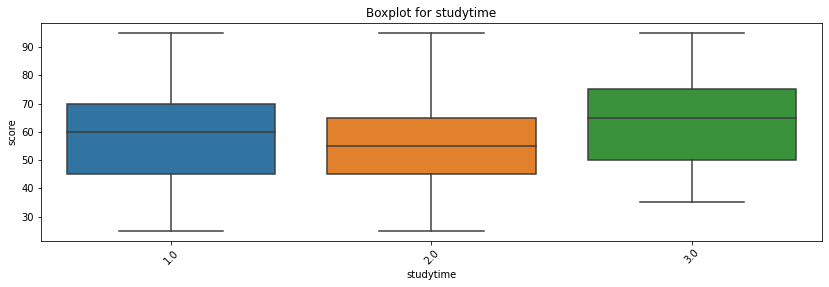

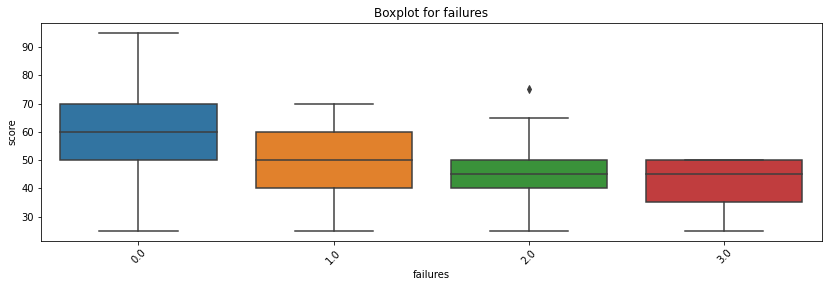

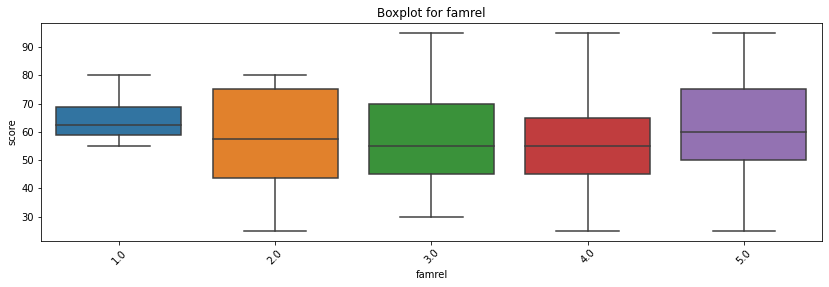

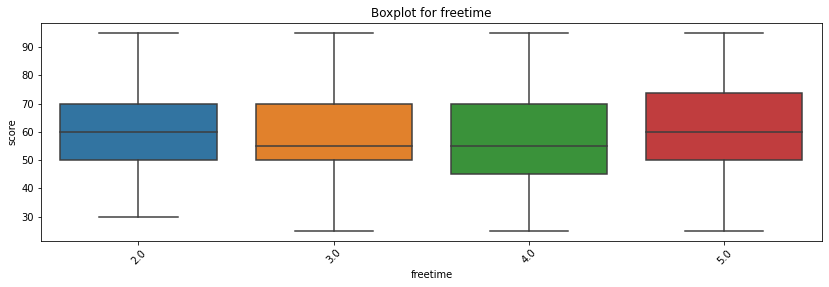

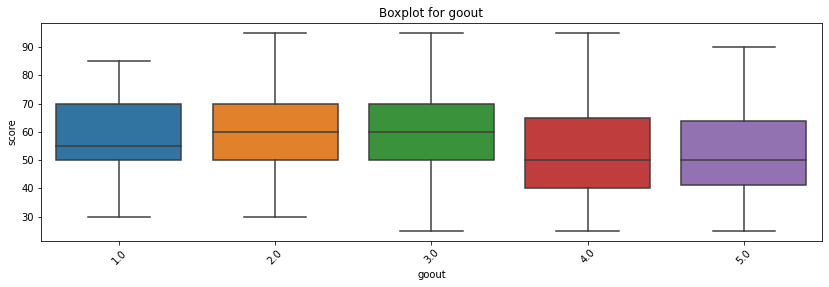

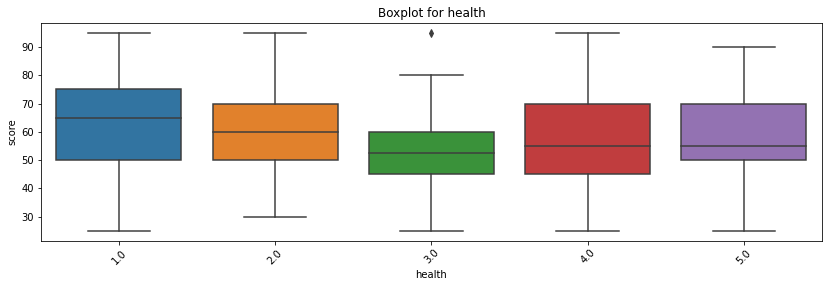

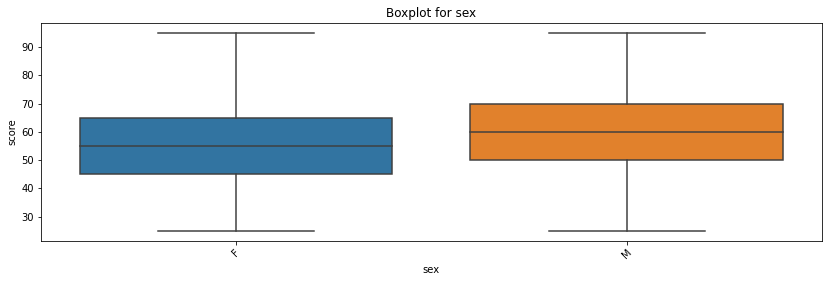

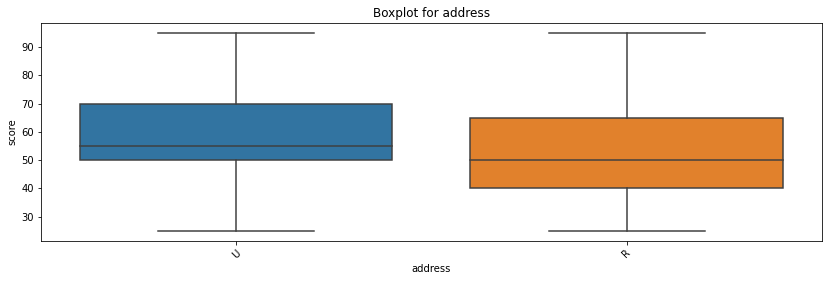

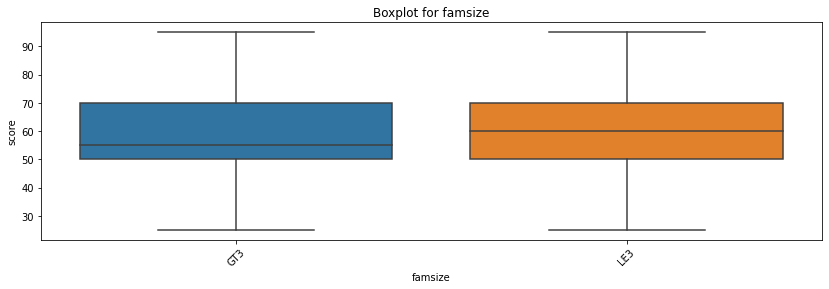

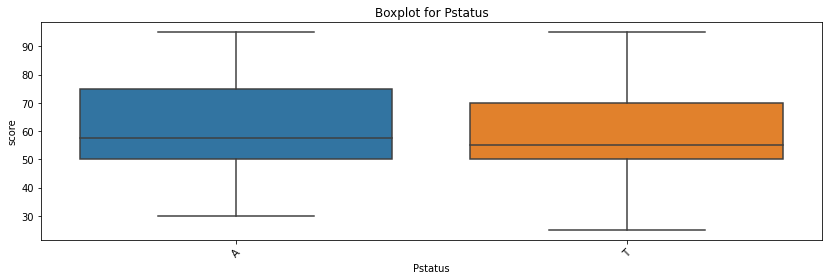

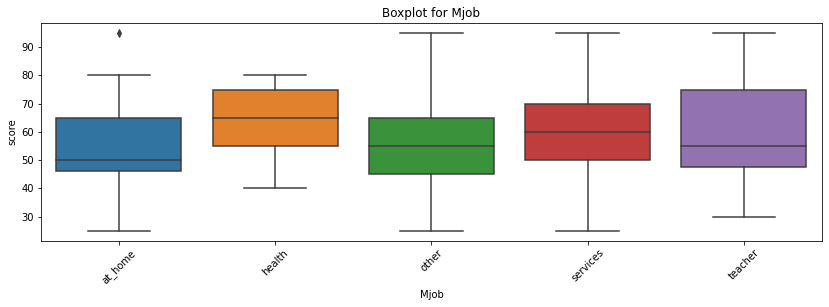

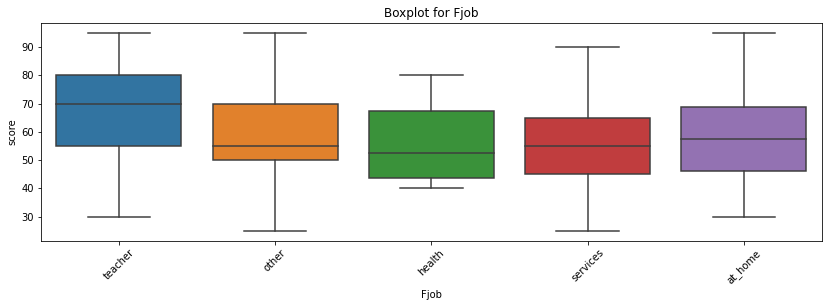

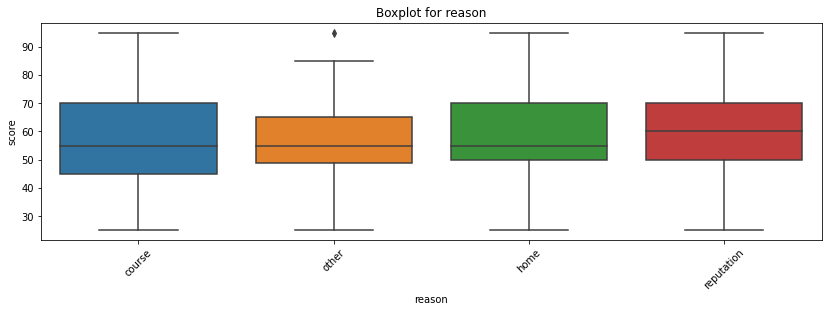

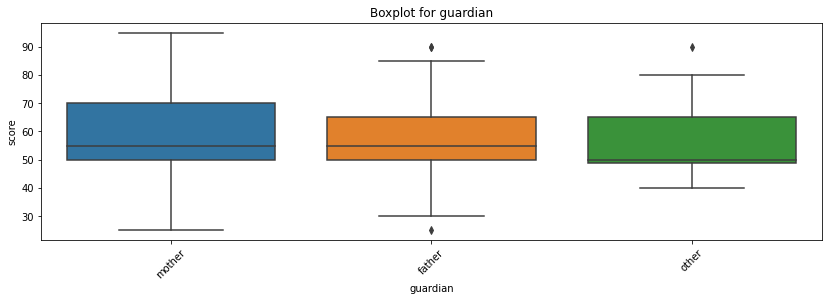

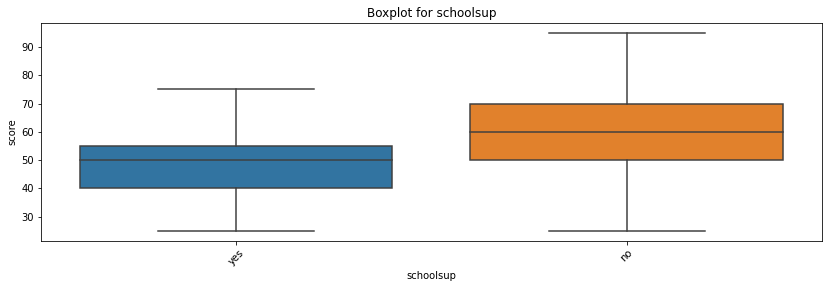

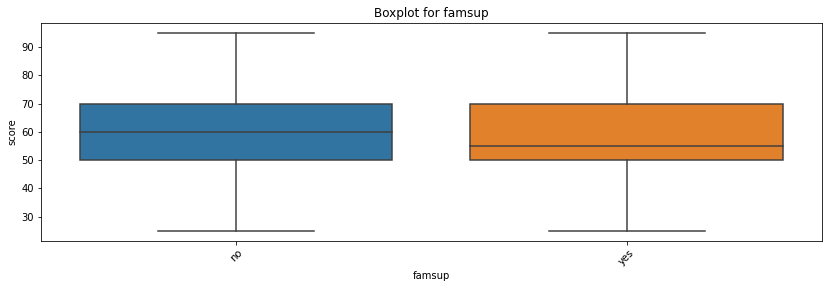

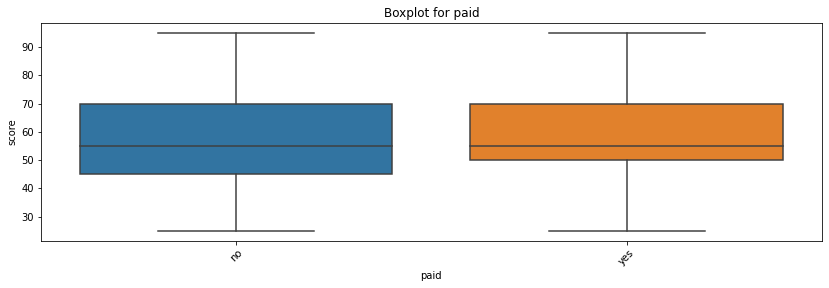

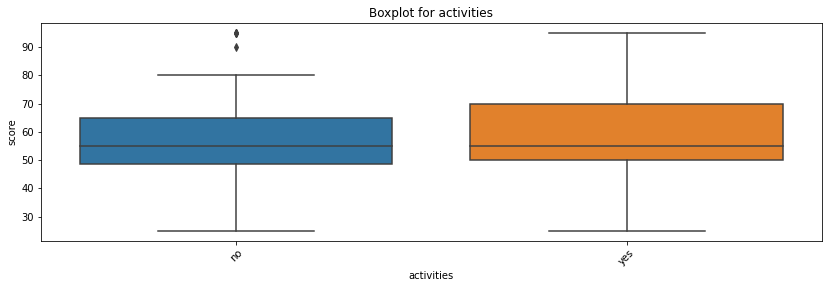

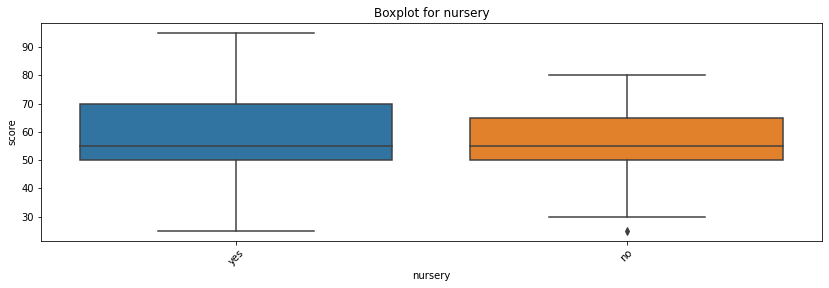

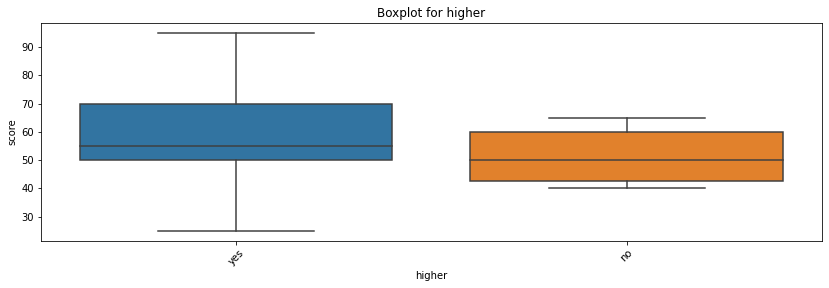

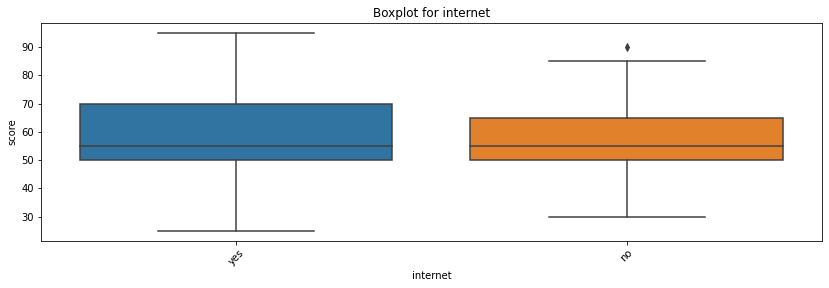

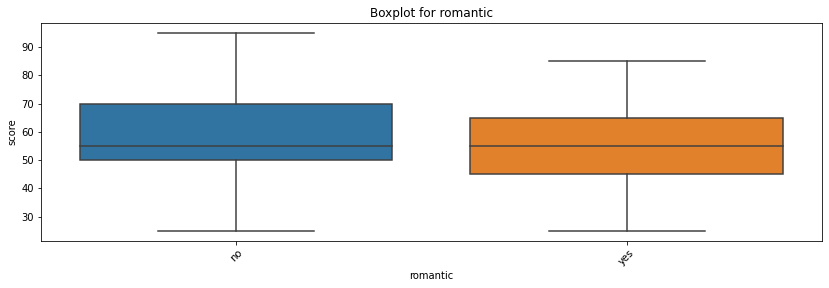

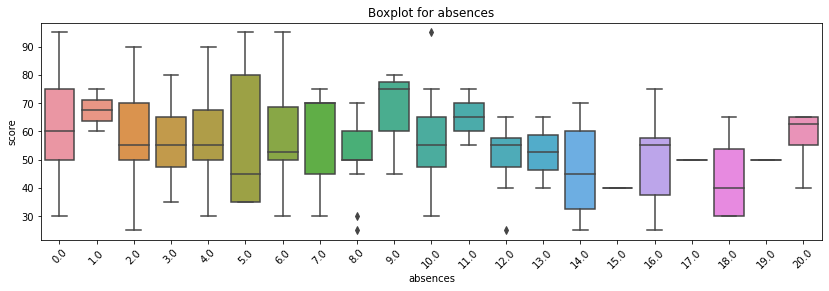

In [150]:
for col in ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'health',
            'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian',
            'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet',
            'romantic', 'absences']:
    get_boxplot(student, col)

### **Выводы:**
Представленные выводы основы только на основе графиков, без анализа статистики.

**Образование матери** -  высшее и отсуствие образования среднем дает более высокий баллы  
**Образование отца** -  отсуствие образования дает наименьший баллы, все остальное одинаково  
**Время в пути до школы**  - не влияет на баллы  
**Время на учёбу помимо школы** - сказываетя на баллы только если тратить болье 5 - 10 часов  
**Количество внеучебных неуда** - чем меньше неудач тем больше быллы  
**Семейные отношения** - не влияют на баллы  
**свободное время после школы**  - не влияют на баллы  
**проведение времени с друзьями** -  чем меньше времени тем лучше баллы  
**Текущее состояние здоровья** - среднее здоровье показывает наименьшие баллы  
**Пол**  - у мужчин больше баллов  
**Тип адреса ученика**  - городские показывают лучше баллы  
**Размер семьи** - не влияет на баллы  
**Статус совместного жилья родителей** - раздельное проживание показывает больше баллы, чем совместное  
**Работа матери** - сфера здравоохранения показывает лучший результат, остальные примерно одинаковы  
**Работа отца** - учитель показывает лучший результат, остальные примерно одинаковы  
**Причина выбора школы** - не влияет на баллы   
**Опекун**  -  не влияет на баллы  
**Дополнительная образовательная поддержка** - при ее отсутствии баллы выше  
**Семейная образовательная поддержка** -  не влияет на баллы    
**Дополнительные платные занятия по математи** - при присутвии балыы немного выше   
**Дополнительные внеучебные занятия**  - не влияет на баллы  
**Посещение детского сада** - при ее присутвии баллы выше  
**Хочет получить высшее образовани** - при ее присутвии баллы выше  
**Наличие интернета дома** - не влияет на баллы  
**В романтических отношениях**  - не влияет на баллы  
**Количество пропущенных занятий** - мало данных для анализа  

**Статистический анализ  равенства средних величин**

Так как выборка для анализа маленькая, предлагается иссдедовать данные на два различных уровня критерия значимости 5% и 7.5%

Как известно критерия значимости - это вероятность отвергнуть нулевую гипотезу при условии, что она верна. Так как выборка у нас небольшая можно перебрегнуть уровнем  критерия значимости, с тем чтобы количество признаков увеличилось. 

***Для критерия значимости 5%***

In [152]:
def get_stat_dif(date, column, level):
    cols = date.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(date.loc[date.loc[:, column] == comb[0], 'score'],
                     date.loc[date.loc[:, column] == comb[1], 'score']).pvalue \
                <= float(level) / len(combinations_all): 
            print('Найдены статистически значимые различия для колонки', column)
            break

In [161]:
for col in ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'health',
            'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian',
            'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet',
            'romantic', 'absences', 'granular']:
    get_stat_dif(student, col, 0.05)

Найдены статистически значимые различия для колонки age
Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Fedu
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки health
Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Fjob
Найдены статистически значимые различия для колонки schoolsup
Найдены статистически значимые различия для колонки granular


***Для критерия значимости 7.5%***

In [160]:
for col in ['age','Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'health',
            'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian',
            'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet',
            'romantic', 'absences', 'granular']:
    get_stat_dif(student, col, 0.075)

Найдены статистически значимые различия для колонки age
Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Fedu
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки health
Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Fjob
Найдены статистически значимые различия для колонки schoolsup
Найдены статистически значимые различия для колонки absences
Найдены статистически значимые различия для колонки granular


На основое анализа сравнения этих двух выборок на баллы по госэкзамену по математике влияют следующие признаки:
- age (возраст ученика)
- Medu (образование матери)
- Fedu (образование отца)
- studytime (время на учёбу помимо школы в неделю)
- failures (количество внеучебных неудач)
- health (текущее состояние здоровья)
- sex (пол)
- address (тип адреса ученика)
- Fjob (работа отца)
- absences (количество пропусков)

На остнове корреляционног анализа выяснили, что параметр studytime обратно пропорционален granular В результирующей выборке оставим параметр только granular и удалим studytime


### 6. Выводы

На основе анализа выделим те параметры , которые оказывают влиние на баллы по госэкзамену по математике (score)

age  -  возраст ученика
Medu - образование матери
Fedu  - образование отца
failures - количество внеучебных неудач
health - текущее состояние здоровья
sex - пол
address  - тип адреса ученика
Fjob  - работа отца
absences  - количество пропусков
granular - неизвестный параметр

Таким образом из 28 признаков осталось 10 признаков которые как было показано статистически влияют на остоговую оценку по математике.
